In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

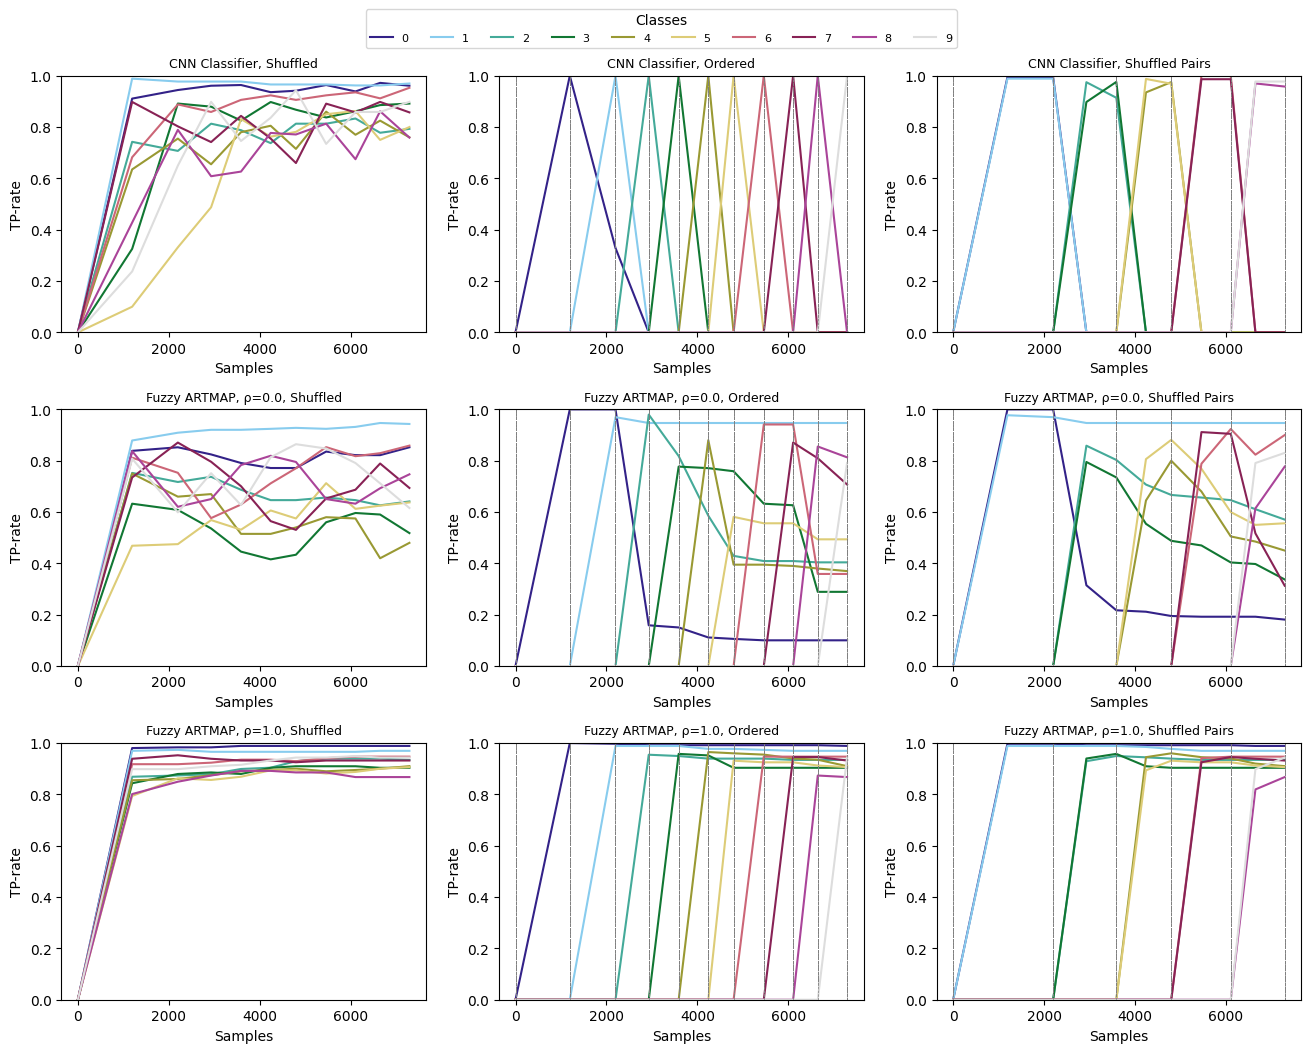

In [90]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import numpy as np
import pandas as pd

tol_colors = [
    "#332288", "#88CCEE", "#44AA99", "#117733", 
    "#999933", "#DDCC77", "#CC6677", "#882255", 
    "#AA4499", "#DDDDDD"
]



data = pd.read_parquet("USPS.parquet")

def rename(row):
    if "ART" in row["model"]:
        return f"{row['model']}, ρ={row['rho']}"
    return row["model"]

data["model"] = data.apply(lambda row: rename(row), axis=1)
data["model"].unique()


# Create subplots with a larger figure size to accommodate legends
models = sorted(data["model"].unique().tolist())
M = len(data["model"].unique())
fig, ax = plt.subplots(M, 3, figsize=(16, 12))  # Adjust figure size for extra space

# Use the first model's target names for the global legend (assumes all models have the same target names)
global_target_names = data[data["model"] == models[0]]["target_names"].iloc[0].tolist()  # Convert to list

for m, model in enumerate(models):
    for s, shuffle in enumerate(["True", "False", "semi"]):
        acc_mat = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["accuracy_by_class_iterative"].iloc[0]

        target_names = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["target_names"].iloc[0]
        acc_mat = acc_mat.reshape((-1, len(target_names)))
        batch_sizes = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["batch_size"].iloc[0]

        for i, target in enumerate(target_names):
            y = acc_mat[:, i].tolist()
            x = np.cumsum(batch_sizes).tolist()
            y.insert(0, 0)
            x.insert(0, 0)
            ax[m, s].plot(x, y, label=target, color=tol_colors[i % len(tol_colors)])

            # Add vertical lines at x points
            if shuffle == "False":
                for x_point in x:
                    ax[m, s].axvline(x=x_point, color='gray', linestyle='--', linewidth=0.5)
            elif shuffle == "semi":
                for x_point in x[::2]:
                    ax[m, s].axvline(x=x_point, color='gray', linestyle='--', linewidth=0.5)

        # Add title
        if shuffle == "True":
            shuffle_text = "Shuffled" 
        elif shuffle == "semi":
            shuffle_text = "Shuffled Pairs"  
        else:
            shuffle_text = "Ordered"
        ax[m, s].set_title(f"{model.replace("ART", " ARTMAP").replace("CNN", "CNN ")}, {shuffle_text}", fontsize=9)
        ax[m, s].set_ylim(0, 1)
        # ax[m, s].grid()
        ax[m, s].set_xlabel("Samples")
        ax[m, s].set_ylabel("TP-rate")
        # ax[m, s].set_yscale("log")

# Add a single legend just below the title
fig.legend(
    handles=ax[0, 0].lines[:len(global_target_names)],  # Use the lines from the first plot
    labels=global_target_names,  # Target names as labels
    loc='upper center',
    bbox_to_anchor=(0.5, 0.94),  # Adjust position below the title
    ncol=len(global_target_names),  # Spread across columns
    fontsize=8,
    title="Classes"
)

# Adjust layout to leave space for the legend
fig.subplots_adjust(top=0.88, hspace=0.3)  # Reduce the top margin to leave space for the legend

# Add a main title for the entire figure
# fig.suptitle("True-Positive Rate by Class, USPS", fontsize=16, y=0.98)  # Position the title above the legend
plt.savefig("Accuracy_by_class_usps.png")
plt.show()


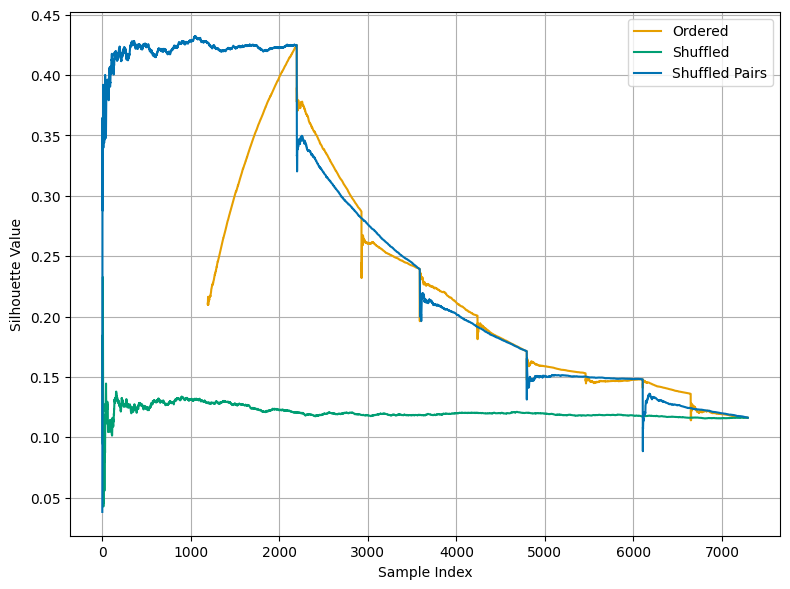

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define the color map
okabe_ito_cmap = ListedColormap([
    "#E69F00", "#009E73", "#0072B2"
])

# List of shuffles and corresponding filenames
shuffles = ["False", "True", "semi"]
file_names = [f"iterative_silhouette_shuffle_{shuffle}.csv" for shuffle in shuffles]

# Label mapping for the legend and titles
shuffle_labels = {
    "False": "Ordered",
    "True": "Shuffled",
    "semi": "Shuffled Pairs"
}

# Create the figure for the main plot
fig, main_ax = plt.subplots(figsize=(8, 6))

# Iterate over the shuffles, files, and colors
for i, (shuffle, file_name) in enumerate(zip(shuffles, file_names)):
    # Load the data
    data = pd.read_csv(file_name)
    
    # Extract x and y values
    x = data["Sample Index"]
    y = data["Iterative Silhouette"]

    # Plot silhouette values on the main subplot
    main_ax.plot(x, y, label=shuffle_labels[shuffle], color=okabe_ito_cmap(i))

# Configure main silhouette plot
# main_ax.set_title("Iterative Silhouette Score, USPS")
main_ax.set_xlabel("Sample Index")
main_ax.set_ylabel("Silhouette Value")
main_ax.legend()
main_ax.grid(True)

plt.tight_layout()
plt.savefig("silhouette_usps.png", bbox_inches='tight'))
plt.show()


C:\Users\nikla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\nikla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


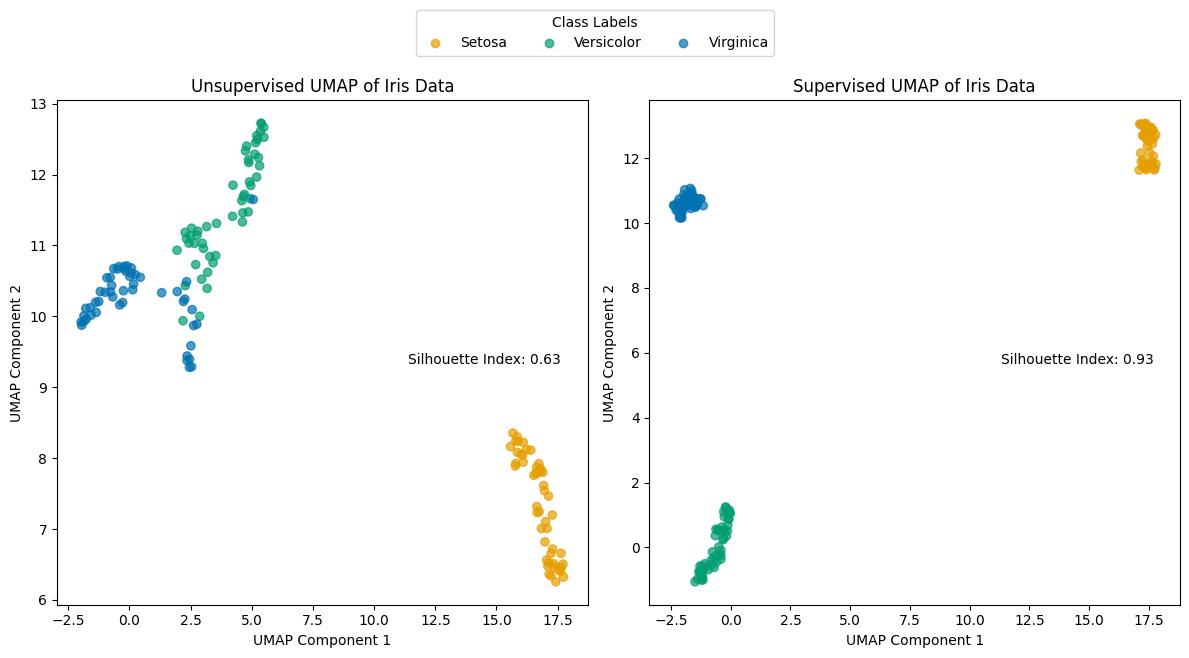

In [103]:
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

# Load Iris dataset
iris = datasets.load_iris()
X_train = iris.data
y_train = iris.target
target_names = iris.target_names  # Class names: ['setosa', 'versicolor', 'virginica']

# Okabe-Ito colormap without gray color
okabe_ito_cmap = ListedColormap([
    "#E69F00", "#009E73",
    "#0072B2",
])

# Supervised UMAP (with labels) - Keeping 4 components, plotting only 2
reducer_supervised = umap.UMAP(n_components=4, random_state=42)
X_umap_supervised = reducer_supervised.fit_transform(X_train, y=y_train)

# Unsupervised UMAP (without labels) - Keeping 4 components, plotting only 2
reducer_unsupervised = umap.UMAP(n_components=4, random_state=42)
X_umap_unsupervised = reducer_unsupervised.fit_transform(X_train)

# Silhouette scores (calculated in full 4D space)
sil_score_umap_supervised = silhouette_score(X_umap_supervised, y_train)
sil_score_umap_unsupervised = silhouette_score(X_umap_unsupervised, y_train)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)

# Unsupervised UMAP plot
scatter_umap_unsupervised = axes[0].scatter(X_umap_unsupervised[:, 0], X_umap_unsupervised[:, 1], 
                                            c=y_train, cmap=okabe_ito_cmap, alpha=0.7)
axes[0].set_title("Unsupervised UMAP of Iris Data")
axes[0].set_xlabel("UMAP Component 1")
axes[0].set_ylabel("UMAP Component 2")
axes[0].text(0.95, 0.5, f'Silhouette Index: {sil_score_umap_unsupervised:.2f}', 
             transform=axes[0].transAxes, fontsize=10, va='top', ha='right')

# Supervised UMAP plot
scatter_umap_supervised = axes[1].scatter(X_umap_supervised[:, 0], X_umap_supervised[:, 1], 
                                          c=y_train, cmap=okabe_ito_cmap, alpha=0.7)
axes[1].set_title("Supervised UMAP of Iris Data")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")
axes[1].text(0.95, 0.5, f'Silhouette Index: {sil_score_umap_supervised:.2f}', 
             transform=axes[1].transAxes, fontsize=10, va='top', ha='right')

# Custom legend with actual class names
handles, _ = scatter_umap_unsupervised.legend_elements()
legend_labels = [target_names[i].title() for i in np.unique(y_train)]
fig.legend(handles, legend_labels, title="Class Labels", loc="upper center", 
           bbox_to_anchor=(0.5, 1.1), ncol=3)

# Main title for the entire figure
# fig.suptitle("Iris Data Visualization with UMAP", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("iris_umap_projections.png", bbox_inches='tight')
plt.show()


In [98]:
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from Data import load_usps

# Load USPS dataset
X_train, y_train, X_test, y_test = load_usps(
    random_state=42,
    shuffle=False
)

# Paul Tol colormap
tol_colors = [
    "#332288", "#88CCEE", "#44AA99", "#117733", 
    "#999933", "#DDCC77", "#CC6677", "#882255", 
    "#AA4499", "#DDDDDD"
]
tol_cmap = ListedColormap(tol_colors)

# Supervised UMAP (with labels) - Keeping 256 components, plotting only 2
reducer_supervised = umap.UMAP(n_components=256, random_state=42)
X_umap_supervised = reducer_supervised.fit_transform(X_train, y=y_train)

# Unsupervised UMAP (without labels) - Keeping 256 components, plotting only 2
reducer_unsupervised = umap.UMAP(n_components=256, random_state=42)
X_umap_unsupervised = reducer_unsupervised.fit_transform(X_train)

# Silhouette scores (calculated in full 256D space)
sil_score_umap_supervised = silhouette_score(X_umap_supervised, y_train)
sil_score_umap_unsupervised = silhouette_score(X_umap_unsupervised, y_train)

C:\Users\nikla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\nikla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


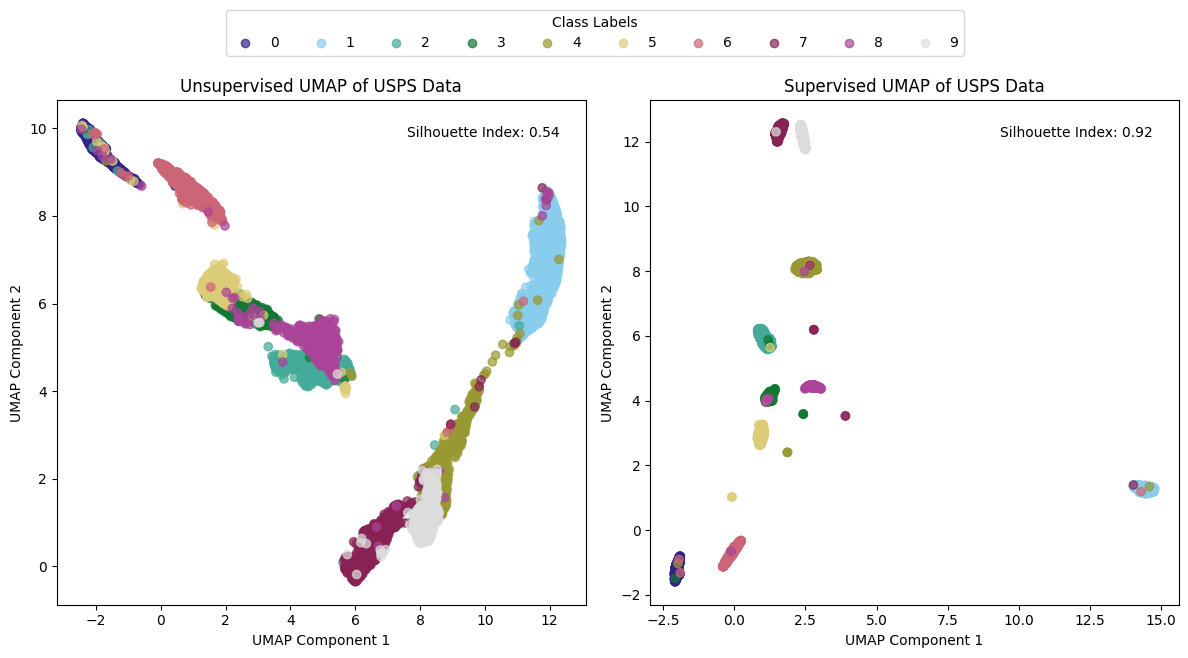

In [101]:
# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)

# Unsupervised UMAP plot
scatter_umap_unsupervised = axes[0].scatter(X_umap_unsupervised[:, 0], X_umap_unsupervised[:, 1], 
                                            c=y_train, cmap=tol_cmap, alpha=0.7)
axes[0].set_title("Unsupervised UMAP of USPS Data")
axes[0].set_xlabel("UMAP Component 1")
axes[0].set_ylabel("UMAP Component 2")
axes[0].text(0.95, 0.95, f'Silhouette Index: {sil_score_umap_unsupervised:.2f}', 
             transform=axes[0].transAxes, fontsize=10, va='top', ha='right')

# Supervised UMAP plot
scatter_umap_supervised = axes[1].scatter(X_umap_supervised[:, 0], X_umap_supervised[:, 1], 
                                          c=y_train, cmap=tol_cmap, alpha=0.7)
axes[1].set_title("Supervised UMAP of USPS Data")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")
axes[1].text(0.95, 0.95, f'Silhouette Index: {sil_score_umap_supervised:.2f}', 
             transform=axes[1].transAxes, fontsize=10, va='top', ha='right')

# Shared legend with numeric class labels
handles, _ = scatter_umap_unsupervised.legend_elements()
fig.legend(handles, list(map(str, range(10))), title="Class Labels", loc="upper center", 
           bbox_to_anchor=(0.5, 1.1), ncol=10)

# Main title for the entire figure
# fig.suptitle("USPS Data Visualization with UMAP", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("usps_umap_projections.png", bbox_inches='tight')
plt.show()

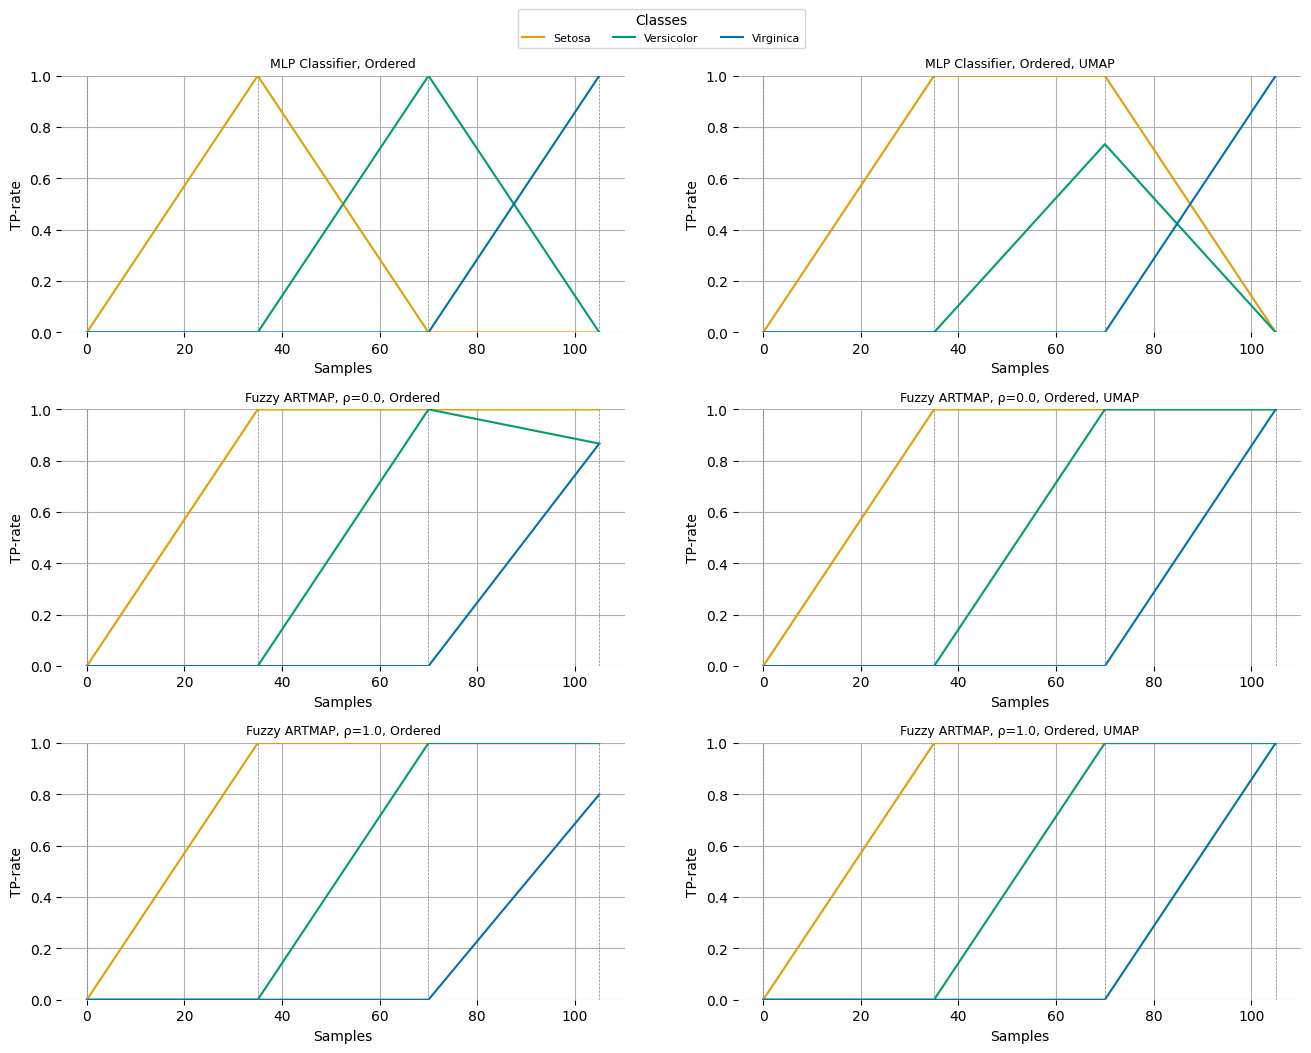

In [81]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import numpy as np
import pandas as pd

tol_colors = [
    "#E69F00", "#009E73",
    "#0072B2",
]


data1 = pd.read_parquet("iris.parquet")
data1 = data1.assign(prep = None)

data2 = pd.read_parquet("iris_umap.parquet")
data2 = data2.assign(prep = "umap")
data = pd.concat([data1, data2], ignore_index=True)

def rename(row):
    if "ART" in row["model"]:
        return f"{row['model']}, ρ={row['rho']}"
    return row["model"]

data["model"] = data.apply(lambda row: rename(row), axis=1)

def rename_shuffle(row):
    if row["prep"] is not None:
        return f"{row['shuffle']}, UMAP"
    else:
        return row["shuffle"]

data["shuffle"] = data.apply(lambda row: rename_shuffle(row), axis=1)


# Create subplots with a larger figure size to accommodate legends
models = sorted(data["model"].unique().tolist())
M = len(models)
fig, ax = plt.subplots(M, 2, figsize=(16, 12))  # Adjust figure size for extra space

# Use the first model's target names for the global legend (assumes all models have the same target names)
global_target_names = data[data["model"] == models[0]]["target_names"].iloc[0].tolist()  # Convert to list

for m, model in enumerate(models):
    for s, shuffle in enumerate(["False", "False, UMAP"]):
        acc_mat = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["accuracy_by_class_iterative"].iloc[0]

        target_names = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["target_names"].iloc[0]
        acc_mat = acc_mat.reshape((-1, len(target_names)))
        batch_sizes = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["batch_size"].iloc[0]

        for i, target in enumerate(target_names):
            y = acc_mat[:, i].tolist()
            x = np.cumsum(batch_sizes).tolist()
            y.insert(0, 0)
            x.insert(0, 0)
            ax[m, s].plot(x, y, label=target, color=tol_colors[i % len(tol_colors)])

            # Add vertical lines at x points
            if i == len(target_names)-1:
                for x_point in x:
                    ax[m, s].axvline(x=x_point, color='gray', linestyle='--', linewidth=0.5)

        # Add title
        shuffle_text = shuffle.replace("False","Ordered")
        ax[m, s].set_title(f"{model.replace("ART", " ARTMAP").replace("CustomMLP", "MLP ")}, {shuffle_text}", fontsize=9)
        ax[m, s].set_ylim(0, 1)
        ax[m, s].grid()
        ax[m, s].set_xlabel("Samples")
        ax[m, s].set_ylabel("TP-rate")
        ax[m, s].spines['top'].set_visible(False)
        ax[m, s].spines['right'].set_visible(False)
        ax[m, s].spines['bottom'].set_visible(False)
        ax[m, s].spines['left'].set_visible(False)
        # ax[m, s].set_yscale("log")

# Add a single legend just below the title
iris = datasets.load_iris()
target_names = iris.target_names
legend_labels = [target_names[i].title() for i in range(3)]
fig.legend(
    handles=ax[0, 0].lines[:3],  # Use the lines from the first plot
    labels=legend_labels,  # Target names as labels
    loc='upper center',
    bbox_to_anchor=(0.5, 0.94),  # Adjust position below the title
    ncol=len(global_target_names),  # Spread across columns
    fontsize=8,
    title="Classes"
)

# Adjust layout to leave space for the legend
fig.subplots_adjust(top=0.88, hspace=0.)  # Reduce the top margin to leave space for the legend

# Add a main title for the entire figure
fig.suptitle("True-Positive Rate by Class, Iris", fontsize=16, y=0.98)  # Position the title above the legend
plt.savefig("Accuracy_by_class_iris.png")
plt.show()


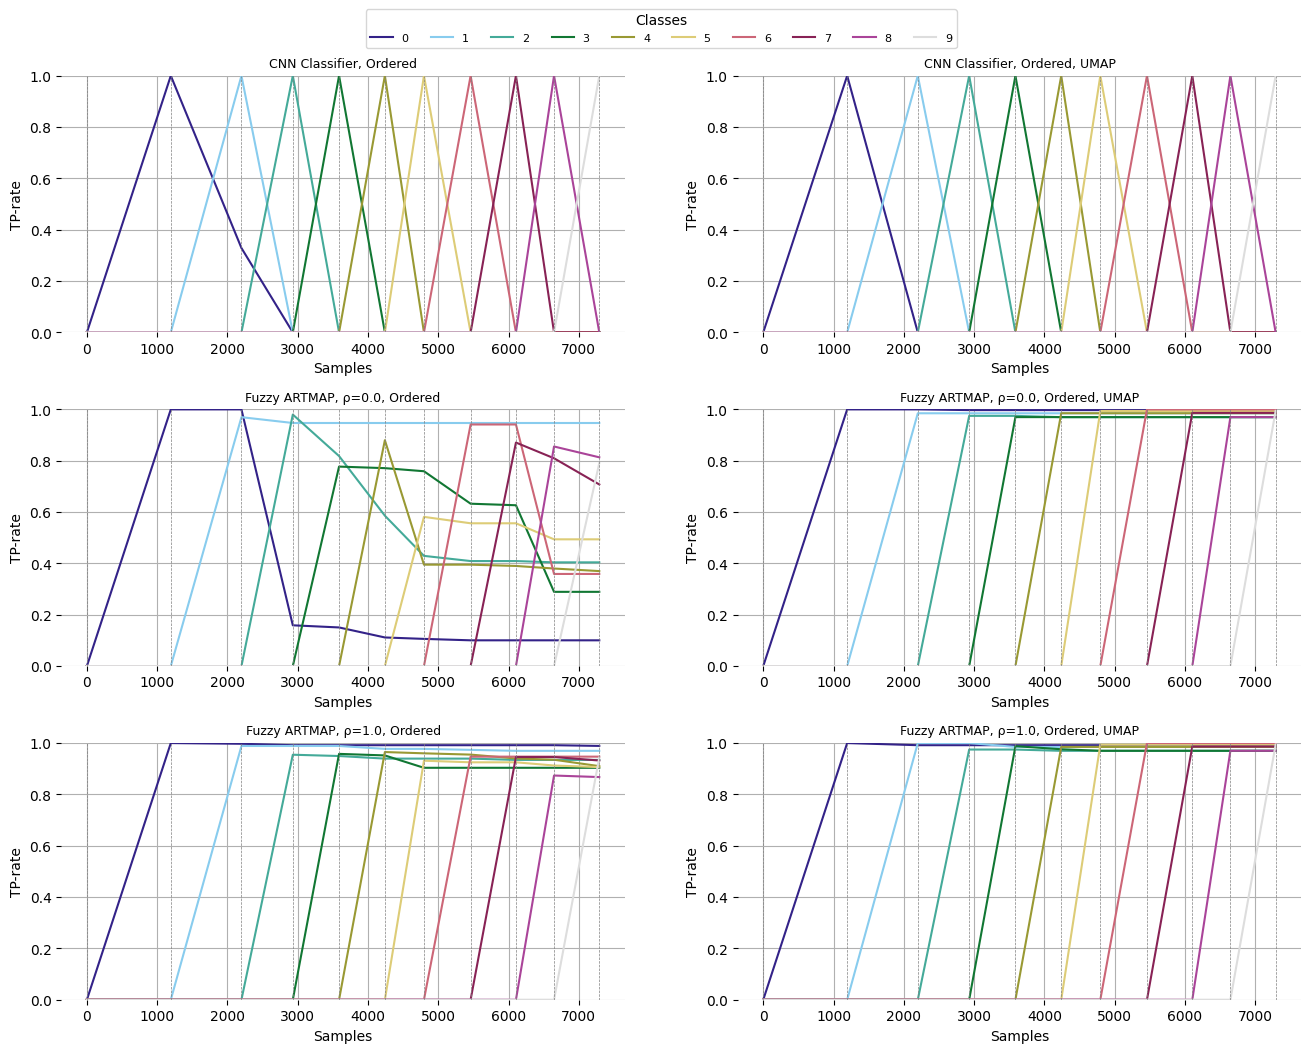

In [80]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import numpy as np
import pandas as pd

tol_colors = [
    "#332288", "#88CCEE", "#44AA99", "#117733", 
    "#999933", "#DDCC77", "#CC6677", "#882255", 
    "#AA4499", "#DDDDDD"
]

data1 = pd.read_parquet("usps.parquet")
data1 = data1.assign(prep = None)

data2 = pd.read_parquet("usps_umap.parquet")
data2 = data2.assign(prep = "umap")
data = pd.concat([data1, data2], ignore_index=True)

def rename(row):
    if "ART" in row["model"]:
        return f"{row['model']}, ρ={row['rho']}"
    return row["model"]

data["model"] = data.apply(lambda row: rename(row), axis=1)

def rename_shuffle(row):
    if row["prep"] is not None:
        return f"{row['shuffle']}, UMAP"
    else:
        return row["shuffle"]

data["shuffle"] = data.apply(lambda row: rename_shuffle(row), axis=1)


# Create subplots with a larger figure size to accommodate legends
models = sorted(data["model"].unique().tolist())
M = len(models)
fig, ax = plt.subplots(M, 2, figsize=(16, 12))  # Adjust figure size for extra space

# Use the first model's target names for the global legend (assumes all models have the same target names)
global_target_names = data[data["model"] == models[0]]["target_names"].iloc[0].tolist()  # Convert to list

for m, model in enumerate(models):
    for s, shuffle in enumerate(["False", "False, UMAP"]):
        acc_mat = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["accuracy_by_class_iterative"].iloc[0]

        target_names = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["target_names"].iloc[0]
        acc_mat = acc_mat.reshape((-1, len(target_names)))
        batch_sizes = data[(data["model"] == model) & (data["shuffle"] == shuffle)]["batch_size"].iloc[0]

        for i, target in enumerate(target_names):
            y = acc_mat[:, i].tolist()
            x = np.cumsum(batch_sizes).tolist()
            y.insert(0, 0)
            x.insert(0, 0)
            ax[m, s].plot(x, y, label=target, color=tol_colors[i % len(tol_colors)])

            # Add vertical lines at x points
            if i == len(target_names)-1:
                for x_point in x:
                    ax[m, s].axvline(x=x_point, color='gray', linestyle='--', linewidth=0.5)

        # Add title
        shuffle_text = shuffle.replace("False","Ordered")
        ax[m, s].set_title(f"{model.replace("ART", " ARTMAP").replace("CNN", "CNN ")}, {shuffle_text}", fontsize=9)
        ax[m, s].set_ylim(0, 1)
        ax[m, s].grid()
        ax[m, s].set_xlabel("Samples")
        ax[m, s].set_ylabel("TP-rate")
        ax[m, s].spines['top'].set_visible(False)
        ax[m, s].spines['right'].set_visible(False)
        ax[m, s].spines['bottom'].set_visible(False)
        ax[m, s].spines['left'].set_visible(False)
        # ax[m, s].set_yscale("log")

# Add a single legend just below the title
legend_labels = [str(i) for i in range(10)]
fig.legend(
    handles=ax[0, 0].lines[:10],  # Use the lines from the first plot
    labels=legend_labels,  # Target names as labels
    loc='upper center',
    bbox_to_anchor=(0.5, 0.94),  # Adjust position below the title
    ncol=len(global_target_names),  # Spread across columns
    fontsize=8,
    title="Classes"
)

# Adjust layout to leave space for the legend
fig.subplots_adjust(top=0.88, hspace=0.3)  # Reduce the top margin to leave space for the legend

# Add a main title for the entire figure
# fig.suptitle("True-Positive Rate by Class, USPS", fontsize=16, y=0.98)  # Position the title above the legend
plt.savefig("Accuracy_by_class_usps_umap.png")
plt.show()


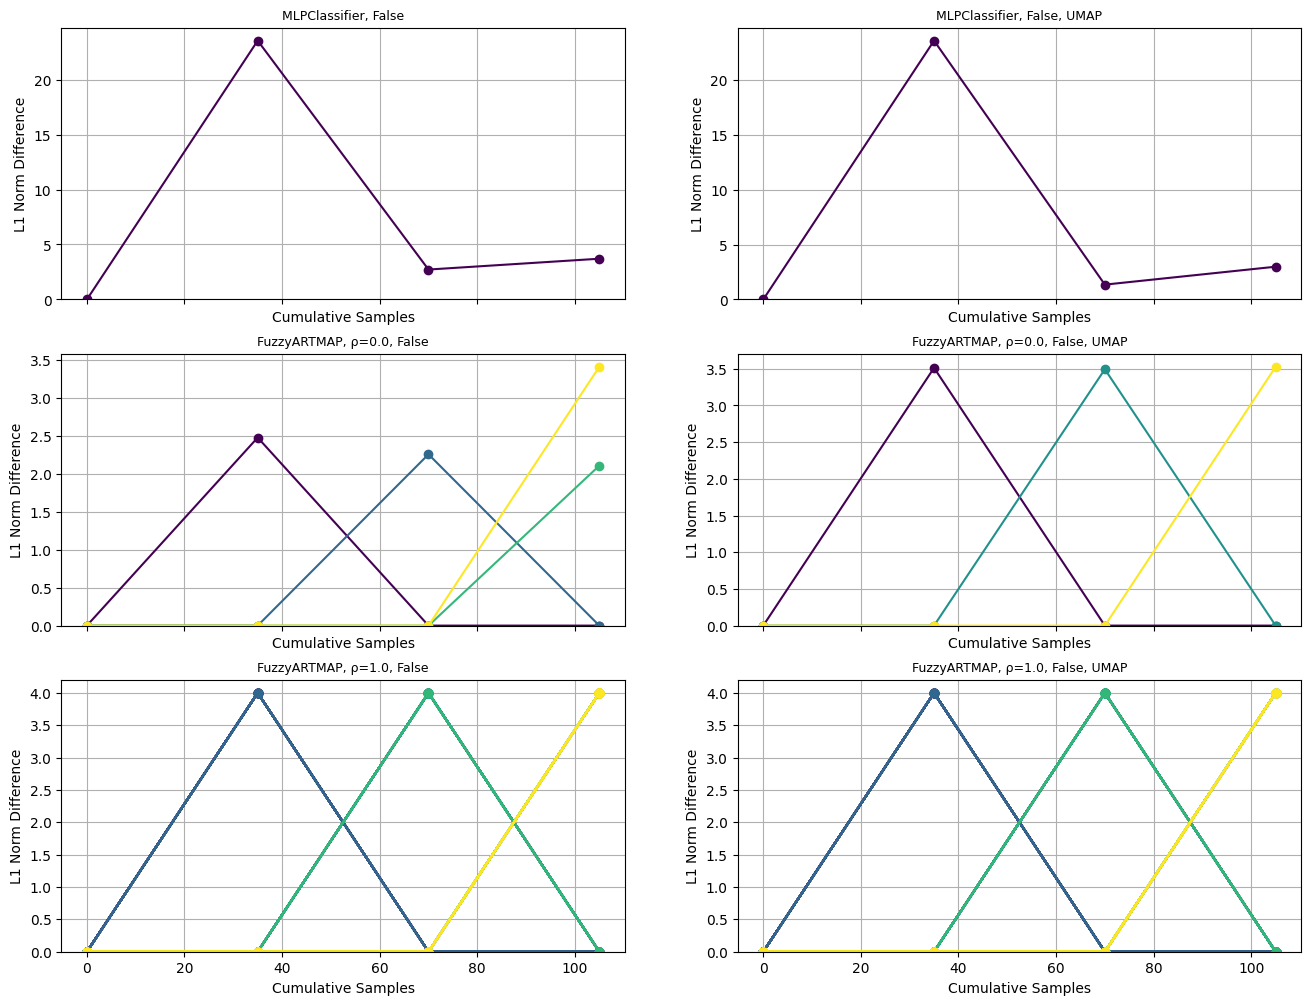

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import viridis

# Load the parquet data
data1 = pd.read_parquet("iris.parquet")
data1 = data1.assign(prep=None)

data2 = pd.read_parquet("iris_umap.parquet")
data2 = data2.assign(prep="umap")
data = pd.concat([data1, data2], ignore_index=True)

def rename(row):
    if "ART" in row["model"]:
        return f"{row['model']}, ρ={row['rho']}"
    return row["model"]

data["model"] = data.apply(lambda row: rename(row), axis=1)

def rename_shuffle(row):
    if row["prep"] is not None:
        return f"{row['shuffle']}, UMAP"
    else:
        return row["shuffle"]

data["shuffle"] = data.apply(lambda row: rename_shuffle(row), axis=1)

import numpy as np

import numpy as np

# Function to calculate L1 differences for MLP models
def calculate_l1_diffs_mlp(weights_across_batches, biases_across_batches):
    l1_diffs = []

    for batch_idx in range(len(weights_across_batches)):
        # Flatten and concatenate all class weights in the batch
        curr_weights = np.concatenate([
            np.array(weights_across_batches[batch_idx][class_idx]).flatten()
            for class_idx in range(len(weights_across_batches[batch_idx]))
        ])

        # Include biases if provided
        if biases_across_batches is not None:
            curr_biases = np.concatenate([
                np.array(biases_across_batches[batch_idx][class_idx]).flatten()
                for class_idx in range(len(biases_across_batches[batch_idx]))
            ])
            curr_weights = np.concatenate([curr_weights, curr_biases])

        # Compute L1 norm differences
        if batch_idx == 0:
            l1_diffs.append(custom_norm(curr_weights, "MLP"))  # First batch
        else:
            prev_weights = np.concatenate([
                np.array(weights_across_batches[batch_idx - 1][class_idx]).flatten()
                for class_idx in range(len(weights_across_batches[batch_idx - 1]))
            ])

            # Include previous biases if available
            if biases_across_batches is not None:
                prev_biases = np.concatenate([
                    np.array(biases_across_batches[batch_idx - 1][class_idx]).flatten()
                    for class_idx in range(len(biases_across_batches[batch_idx - 1]))
                ])
                prev_weights = np.concatenate([prev_weights, prev_biases])

            l1_diffs.append(custom_norm(curr_weights - prev_weights, "MLP"))

    return np.array(l1_diffs).reshape((1, -1))



# Function to calculate L1 differences for ART models
def calculate_l1_diffs_art(weights_across_batches, model_name):
    l1_diffs_by_class = []
    prev_class_weights = {}
    max_classes = max(len(batch) for batch in weights_across_batches)

    for batch_idx in range(len(weights_across_batches)):
        current_l1_diffs = []
        specific_art_model = get_specific_art_model(model_name)

        for class_idx in range(len(weights_across_batches[batch_idx])):
            curr_weight = np.array(weights_across_batches[batch_idx][class_idx]).flatten()

            if class_idx not in prev_class_weights:
                current_l1_diffs.append(custom_norm(curr_weight, specific_art_model))  # New class
                prev_class_weights[class_idx] = curr_weight
            else:
                prev_weight = prev_class_weights[class_idx]
                current_l1_diffs.append(custom_norm(curr_weight - prev_weight, specific_art_model))
                prev_class_weights[class_idx] = curr_weight  # Update previous weight

        # Pad the current batch’s L1 diffs if necessary
        current_l1_diffs = np.pad(current_l1_diffs, (0, max_classes - len(current_l1_diffs)), constant_values=0)
        l1_diffs_by_class.append(current_l1_diffs)

    return np.array(l1_diffs_by_class).T  # Transpose to get L1 diffs per class


# Function to calculate L1 differences with padding
def calculate_l1_diffs(weights_across_batches, model_name, model_type, biases_across_batches=None):

    if model_type == "MLP":
        return calculate_l1_diffs_mlp(weights_across_batches, biases_across_batches)
    else:
        return calculate_l1_diffs_art(weights_across_batches, model_name)

def get_specific_art_model(model_name):
    if "FuzzyART" in model_name:
        return "FuzzyART"
    elif "GaussianART" in model_name:
        return "GaussianART"
    elif "HypersphereART" in model_name:
        return "HypersphereART"
    else:
        raise ValueError(f"Unknown ART model: {model_name}")

def custom_norm(weight, model_type):
    if model_type == "FuzzyART":
        # Naive L1 norm
        return np.sum(np.abs(weight))

    elif model_type == "GaussianART":
        # Decompose the weight into its components [mean, sigma]
        d = len(weight) // 2  # Split into [mean, sigma]
        mean, sigma = weight[:d], weight[d:2*d]

        # Apply the custom norm for mean and sigma
        return np.sum(np.abs(mean)) + np.sum(np.abs(sigma))

    elif model_type == "HypersphereART":
        # Split into [centroid, radius]
        d = len(weight) - 1
        centroid, radius = weight[:d], weight[d]

        # L1 norm for centroid, absolute difference for radius
        return np.sum(np.abs(centroid)) + np.abs(radius)

    elif model_type == "MLP":
        # Simple L1 norm for weights and biases combined
        return np.sum(np.abs(weight))

    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Create subplots with a larger figure size to accommodate legends
models = sorted(data["model"].unique().tolist())
M = len(models)
fig, ax = plt.subplots(M, 2, figsize=(16, 12), sharex=True)

for m, model in enumerate(models):
    for s, shuffle in enumerate(["False", "False, UMAP"]):
        experiment_data = data[(data["model"] == model) & (data["shuffle"] == shuffle)]

        if experiment_data.empty:
            continue

        # Extract weights, shapes, and batch sizes for the experiment
        weights_across_batches = experiment_data["weights_across_batches"].iloc[0]
        shapes_across_batches = experiment_data["shapes_across_batches"].iloc[0]
        model_type = experiment_data["model_type"].iloc[0]
        model_name = experiment_data["model"].iloc[0]  # Use this to disambiguate ART models
        batch_sizes = experiment_data["batch_size"].iloc[0]
        
        # Get biases for MLP models if available
        biases_across_batches = experiment_data["biases_across_batches"].iloc[0] if "biases_across_batches" in experiment_data else None

        # Calculate L1 differences
        l1_diffs_by_class = calculate_l1_diffs(weights_across_batches, model_name, model_type, biases_across_batches)

        # Cumulative batch sizes for plotting
        x = np.cumsum(batch_sizes).tolist()
        x.insert(0, 0)  # Insert initial point at 0 samples

        # Dynamic color map based on the number of lines to be plotted
        cmap = viridis(np.linspace(0, 1, l1_diffs_by_class.shape[0]))

        # Filter out NaN/Inf values and find the max L1 norm difference
        valid_diffs = l1_diffs_by_class[np.isfinite(l1_diffs_by_class)].flatten()
        max_l1_diff = np.max(valid_diffs) * 1.05 if valid_diffs.size > 0 else 1e-5  # Default small value if empty

        for class_idx in range(l1_diffs_by_class.shape[0]):
            y = l1_diffs_by_class[class_idx, :].tolist()
            y.insert(0, 0)  # Initial L1 diff is 0

            # Plot L1 norm differences for each class (or concatenated MLP weights)
            ax[m, s].plot(x, y, marker='o', color=cmap[class_idx], label=f"Class {class_idx + 1}" if "ART" in model else model)

        # Set dynamic y-scale for each subplot
        ax[m, s].set_ylim(0, max_l1_diff)

        ax[m, s].set_title(f"{model.replace('ART', 'ARTMAP').replace('CustomMLP', 'MLP')}, {shuffle}", fontsize=9)
        ax[m, s].set_xlabel("Cumulative Samples")
        ax[m, s].set_ylabel("L1 Norm Difference")
        ax[m, s].grid()


iris = datasets.load_iris()
target_names = iris.target_names
legend_labels = [target_names[i].title() for i in range(3)]


# Add a global legend at the bottom of the figure
# fig.legend(ax[1, 0].lines[:3], legend_labels, loc="lower center", ncol=3, fontsize=12, frameon=True)

# Adjust layout to make space for the legend
# fig.subplots_adjust(bottom=0.15)  # Shift subplots up to make space for the legend

# Global title and layout adjustments
# fig.suptitle("L1 Norm of Weight Differences Across Batches (Iris)", fontsize=16, y=0.98)
# fig.subplots_adjust(top=0.88, hspace=0.3)

plt.savefig("L1_norm_differences_iris.png")
plt.show()


C:\Users\nikla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9408 - loss: 0.4018
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8259 - loss: 0.6427
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7894 - loss: 1.1816
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 1.1250
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7478 - loss: 1.3149
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7549 - loss: 1.2789
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7628 - loss: 1.3778
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7922 - loss: 1.1854
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7615 - loss: 1.4765
63/63 ━━━━━

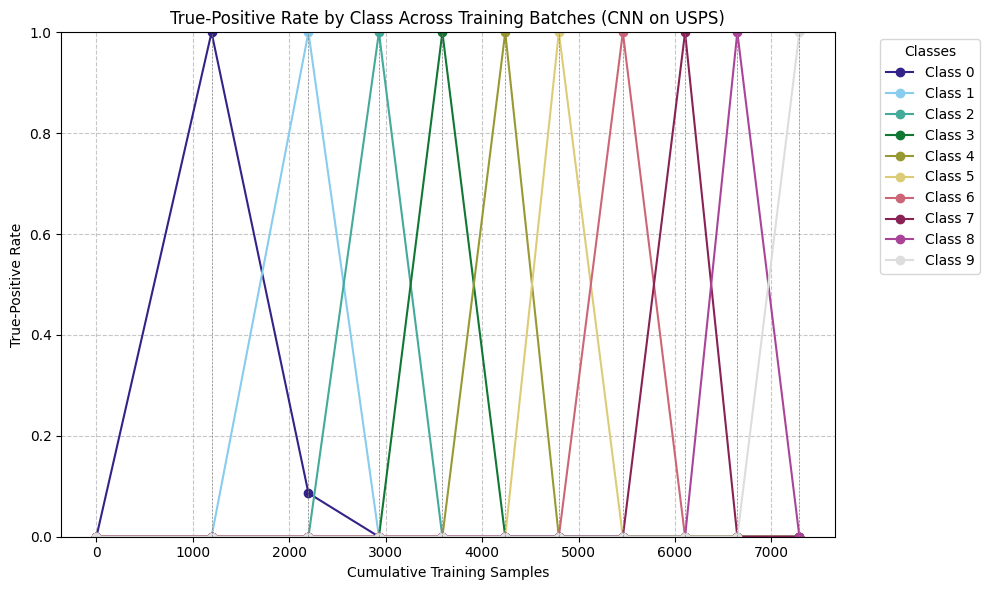

In [39]:
from Data import load_usps
from CNNClassifier import CNNClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# CNN Parameters
CNN_PARAMS = {
    "input_shape": (16, 16, 1),
    "num_classes": 10,
    "conv_layers": [(32, (3, 3))],
    "pool_size": (2, 2),
    "dense_layers": [128],
    "dropout": 0.5,
    "learning_rate": 0.01,
    "epochs": 50,
    "batch_size": 8
}

# Load USPS dataset
X_train, y_train, X_test, y_test = load_usps(random_state=42, shuffle=False)

# Reshape for CNN input
X_train = X_train.reshape((-1, 16, 16, 1))
X_test = X_test.reshape((-1, 16, 16, 1))

# Initialize CNN
cnn = CNNClassifier(**CNN_PARAMS)

# Generate dynamically sized batches
change_indices = np.where(np.diff(np.sort(y_train)) != 0)[0] + 1
change_indices = np.concatenate(([0], change_indices, [len(y_train)]))
batch_idxs = list(zip(change_indices[:-1], change_indices[1:]))

# Initialize tracking lists
target_names = sorted(np.unique(y_test))
tp_rates_by_class = {str(c): [] for c in target_names}  # Track TPR per class
batch_sizes = []
cumulative_samples = []

# Train incrementally and record per-class TP rates
for start_idx, end_idx in batch_idxs:
    # Extract batch data
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]

    # Train the model on the current batch
    cnn.partial_fit(X_batch, y_batch, classes=target_names)

    # Predict on the test set and compute confusion matrix
    y_pred = cnn.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred, labels=target_names)

    # Compute true-positive rates for each class
    for i, target in enumerate(target_names):
        tp = conf_matrix[i, i]  # True positives for the current class
        total_actual = np.sum(conf_matrix[i, :])  # Total instances of this class
        tp_rate = tp / total_actual if total_actual > 0 else 0
        tp_rates_by_class[str(target)].append(tp_rate)

    # Track cumulative batch size
    batch_sizes.append(end_idx - start_idx)
    cumulative_samples.append(sum(batch_sizes))

# Plotting the true-positive rates per class
plt.figure(figsize=(10, 6))
tol_colors = [
    "#332288", "#88CCEE", "#44AA99", "#117733", 
    "#999933", "#DDCC77", "#CC6677", "#882255", 
    "#AA4499", "#DDDDDD"
]

for i, target in enumerate(target_names):
    # Insert initial zero to ensure plot alignment with samples
    y_values = [0] + tp_rates_by_class[str(target)]
    x_values = [0] + cumulative_samples

    # Plot the TPR progression for the current class
    plt.plot(x_values, y_values, label=f"Class {target}", color=tol_colors[i % len(tol_colors)], marker='o')

# Add vertical grid lines at batch transition points
for x_point in cumulative_samples:
    plt.axvline(x=x_point, color='gray', linestyle='--', linewidth=0.5)

# Final plot customization
plt.title("True-Positive Rate by Class Across Training Batches (CNN on USPS)")
plt.xlabel("Cumulative Training Samples")
plt.ylabel("True-Positive Rate")
plt.ylim(0, 1)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\nikla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


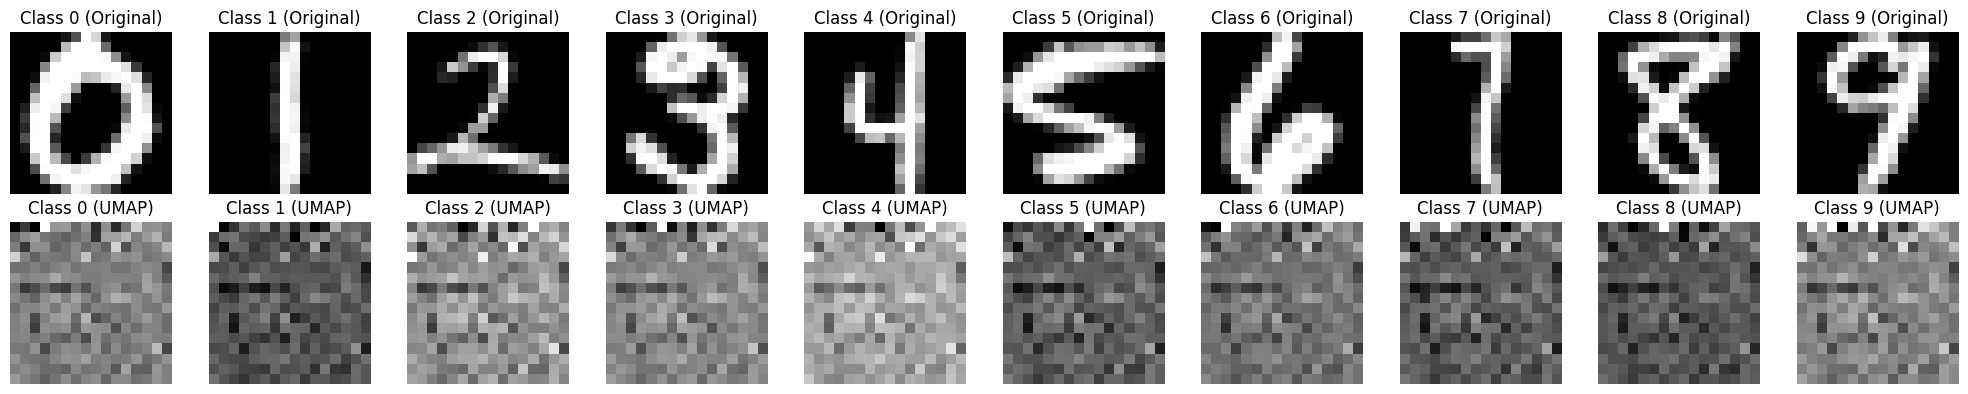

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import train_test_split

# Load the USPS data
X_train, y_train, X_test, y_test = load_usps(random_state=42, shuffle=True)

# Combine train and test sets
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Apply UMAP with 256 components to preserve the 16x16 structure
reducer = umap.UMAP(n_components=256, random_state=42)
X_umap_combined = reducer.fit_transform(X_combined, y=y_combined)

# Select 1 example from each class both before and after the UMAP transform
examples_original = []
examples_umap = []

for cls in np.unique(y_combined):
    idx = np.where(y_combined == cls)[0][0]  # Get the first occurrence of each class
    examples_original.append(X_combined[idx].reshape(16, 16))
    examples_umap.append(X_umap_combined[idx].reshape(16, 16))

# Plot the results
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Original images
    axes[0, i].imshow(examples_original[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Class {i} (Original)")
    
    # UMAP-transformed images
    axes[1, i].imshow(examples_umap[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Class {i} (UMAP)")

plt.tight_layout()
plt.savefig("USPS_UMAP_comparison.png")
plt.show()


In [25]:
X_test.shape

(7291,)

In [27]:
silhouette_score(X_combined, y_combined)

0.111505285

In [28]:
silhouette_score(X_umap_combined, y_combined)

0.9186512

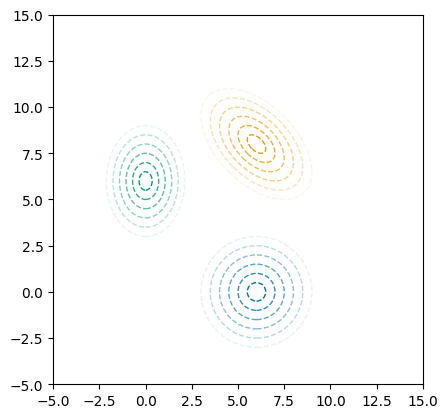

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

okabe_ito_cmap = [
    "#E69F00", "#009E73",
    "#0072B2",
]

def hex_to_rgba_tuple(hex_color: str) -> tuple:
    """Converts a hex color code to an RGBA tuple with normalized values [0,1]."""
    hex_color = hex_color.lstrip('#')

    if len(hex_color) == 6:  # No alpha provided, assume fully opaque
        r, g, b = int(hex_color[:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Fully opaque
    elif len(hex_color) == 8:  # Alpha included
        r, g, b, a = (int(hex_color[i:i+2], 16) for i in range(0, 8, 2))
    else:
        raise ValueError("Hex color must be in the format #RRGGBB or #RRGGBBAA.")

    return (r / 255.0, g / 255.0, b / 255.0, 1.0)



def plot_gaussian_contours_covariance(
    ax: Axes,
    mean: np.ndarray,
    covariance: np.ndarray,
    color: tuple,
    max_std: float = 2.0,
    sigma_steps: float = 0.25,
    linewidth: int = 1,
):
    """Plot concentric ellipses to represent the contours of a 2D Gaussian distribution
    with fading colors. Accepts a covariance matrix to properly represent the
    distribution's orientation and shape.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matplotlib axis object to plot the ellipses.
    mean : np.ndarray
        A numpy array representing the mean (μ) of the distribution.
    covariance : np.ndarray
        A 2x2 numpy array representing the covariance matrix of the distribution.
    color : tuple
        A 4D tuple including RGB and alpha channels to specify the color and
        initial opacity.
    max_std : float, optional
        Maximum number of standard deviations to draw contours to, by default 2.
    sigma_steps : float, optional
        Step size in standard deviations for each contour, by default 0.25.
    linewidth : int, optional
        Width of the boundary line, by default 1.

    """
    from matplotlib.patches import Ellipse

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    major_axis = np.sqrt(
        eigenvalues[0]
    )  # The major axis length (sqrt of larger eigenvalue)
    minor_axis = np.sqrt(
        eigenvalues[1]
    )  # The minor axis length (sqrt of smaller eigenvalue)
    angle = np.arctan2(
        *eigenvectors[:, 0][::-1]
    )  # Angle in radians between the x-axis and the major axis of the ellipse

    # Calculate the number of steps
    steps = int(max_std / sigma_steps)
    alphas = np.linspace(1, 0.1, steps)

    for i, alpha in zip(range(1, steps + 1), alphas):
        # Adjust the alpha value of the color
        current_color = np.copy(color)
        current_color[-1] = alpha  # Update the alpha channel

        # Width and height of the ellipse based on the covariance
        width, height = (
            2 * i * sigma_steps * major_axis * 2,
            2 * i * sigma_steps * minor_axis * 2,
        )
        ellipse = Ellipse(
            xy=(mean[0], mean[1]),
            width=width,
            height=height,
            angle=float(np.degrees(angle)),
            edgecolor=current_color,
            facecolor="None",
            linewidth=linewidth,
            linestyle="dashed",
            label=f"{i * sigma_steps}σ",
        )
        ax.add_patch(ellipse)


m1 = np.array([6.0, 8.0])
m2 = np.array([0.0, 6.0])
m3 = np.array([6.0, 0.0])

s2 = np.array([[0.5, 0.],[0., 1.0]])
s3 = np.array([[1.0, 0.],[0.0, 1.0]])
s1 = np.array([[1.0, -0.5],[-0.5, 1.0]])

colors = [hex_to_rgba_array(hex_c) for hex_c in okabe_ito_cmap]

fig, ax = plt.subplots()
ax.set_xlim(-5, 15)
ax.set_ylim(-5, 15)
ax.set_aspect('equal')

for m, s, c in zip([m1,m2,m3], [s1,s2,s3], colors):
    plot_gaussian_contours_covariance(ax, m, s, c, max_std=1.5)
plt.savefig("sasha_contours.png")
plt.show()

In [120]:
hex_to_rgba_array(okabe_ito_cmap[0])

array([0.9019608 , 0.62352943, 0.        , 1.        ], dtype=float32)